In [1]:
# reload magics
%load_ext autoreload
%autoreload 2

In [2]:
import colorcet as cc
import logging
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy



# create a palette dictionary that has the same keys as the original palette
palette = cc.glasbey_hv
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')


## LOAD DATA

In [6]:
# load the data from the xlsx file
# df = pd.read_excel('../lc-project-data/2024-04-09-DATASET-ML.xlsx')
# df = pd.read_excel('../lc-project-data/2024-04-10-DATASET.xlsx')
df = pd.read_excel('../lc-project-data/2024-04-11-DATASET.xlsx')

In [7]:
df.shape

(5851, 693)

In [ ]:
# preserve a copy for experimentation; we can allways reset to this and faster than reloading the excel file
preserved_df = deepcopy(df)
preserved_df.shape

(5802, 692)

In [ ]:
site_name_dict = {
                  1: 'LDN',
                  2: 'MTL',
                  3: 'SAN',
                  4: 'RIO',
                  5: 'LUS',
                }

## QA

In [ ]:
df = preserved_df

In [ ]:
# summarize the info about the dataframe
# note the number of columns of each type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5802 entries, 0 to 5801
Columns: 692 entries, record_id to biospecimen_complete
dtypes: datetime64[ns](10), float64(656), int64(10), object(16)
memory usage: 30.6+ MB


In [ ]:
# A list of columns to drop
to_drop = []

In [ ]:
# which columns are all nan?
nan_cols = preserved_df.columns[preserved_df.isna().all()].tolist()
print(nan_cols)
to_drop.extend(nan_cols)

['other_hhx4', 'other_hhx5', 'other_hhx6', 'other_hhx7', 'other_hhx8', 'other_hhx9', 'other_hhx10', 'medication8', 'medication9', 'medication11', 'medication12', 'medication13', 'medication14', 'medication15', 'urine', 'pao2', 'sao2', 'ph', 'paco2', 'hco3', 'aexcess', 'alactate', 'clinical_note_upload']


In [ ]:
# values in gender column are very sparse
print(df["gender"].value_counts())
print(f"Nulls = {df['gender'].isna().sum()}")

# drop gender column - mostly NaN
to_drop.append("gender")


gender
FEMALE                123
MALE                   51
Male                    4
TRANSGENDER FEMALE      1
Name: count, dtype: int64
Nulls = 5623


In [ ]:
# adjunctive columns - remove adj2-adj10 as they are all zeroes
adj_cols = [col for col in preserved_df.columns if 'adj' in col]

# info on the adjunctive columns
print(preserved_df[adj_cols].info())
print(preserved_df[adj_cols].describe())
print(preserved_df[adj_cols[1]].value_counts())

# all but the first adjunctive column are zeros/nans
# add them to the list to drop
to_drop.extend(adj_cols[1:])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5802 entries, 0 to 5801
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   adjunctive___1   3328 non-null   float64
 1   adjunctive___2   3324 non-null   float64
 2   adjunctive___3   3215 non-null   float64
 3   adjunctive___4   3215 non-null   float64
 4   adjunctive___5   3215 non-null   float64
 5   adjunctive___6   3215 non-null   float64
 6   adjunctive___7   3215 non-null   float64
 7   adjunctive___8   3215 non-null   float64
 8   adjunctive___9   3215 non-null   float64
 9   adjunctive___10  3215 non-null   float64
dtypes: float64(10)
memory usage: 453.4 KB
None
       adjunctive___1  adjunctive___2  adjunctive___3  adjunctive___4  \
count     3328.000000          3324.0          3215.0          3215.0   
mean         0.032452             0.0             0.0             0.0   
std          0.177224             0.0             0.0             0.0   
m

In [ ]:
print(f"Dropping {len(to_drop)} columns")

to_drop

Dropping 33 columns


['other_hhx4',
 'other_hhx5',
 'other_hhx6',
 'other_hhx7',
 'other_hhx8',
 'other_hhx9',
 'other_hhx10',
 'medication8',
 'medication9',
 'medication11',
 'medication12',
 'medication13',
 'medication14',
 'medication15',
 'urine',
 'pao2',
 'sao2',
 'ph',
 'paco2',
 'hco3',
 'aexcess',
 'alactate',
 'clinical_note_upload',
 'gender',
 'adjunctive___2',
 'adjunctive___3',
 'adjunctive___4',
 'adjunctive___5',
 'adjunctive___6',
 'adjunctive___7',
 'adjunctive___8',
 'adjunctive___9',
 'adjunctive___10']

In [ ]:
try:
    df = preserved_df.drop(columns = to_drop)
except KeyError:
    # already did it and reran the cell
    pass
df.shape

(5802, 659)

In [ ]:
# get all column names
df_columns = df.columns

## TODO

In [ ]:
# TODO: one-hot encode mode of diag


df["mode_of_diag"].value_counts()

mode_of_diag
1.0    3520
2.0     955
0.0     194
5.0      12
3.0       5
4.0       1
Name: count, dtype: int64

# FEATURE SETS

## LC+, LC-, HC

- make a new column to encode status of reach record

In [ ]:
# LC_positive types
pos_vals = [2,4,6,8,9,12,13]
neg_vals = [1,5,7,10,]
hc_vals  = [3,11, 14,15]

LC_pos = df.query('participant_type in @pos_vals')
LC_neg = df.query('participant_type in @neg_vals')
HC     = df.query('participant_type in @hc_vals')


df['LC_STATUS'] = df['participant_type'].apply(lambda x: 'LC_POS' if x in pos_vals else 'LC_NEG' if x in neg_vals else 'HC')

df['LC_STATUS'].value_counts()

LC_STATUS
LC_NEG    3260
LC_POS    2461
HC          81
Name: count, dtype: int64

## DEMOGRAPHICS

In [ ]:
# record id
# we should leave this out - it is not useful as a feature
# it is a unique identifier for the record, but has various formats: ints, strings, uuids, etc and 
RECORDS = ["record_id"]

# demographics etc
DEMOGRAPHICS = ["sex", 
                "age", 
                # "home_location", 
                # "living_with", 
                # "number_of_persons_in_house"
                ]

# suggest leaving this out
# country of birth - not sure how useful this is
# there are about 100 different countries in the dataset, 
# with a long tail
BIRTH_COUNTRY    = [
                # "country"
                ]

# employment etc
# data is sparse, multilingual, and not useful
EMPLOYMENT   = [
                # "employed", 
                # "occupation", 
                "hcp", 
                "micro"
                ]

# the site at which the data was collected
# consider renaming this feature below
SITES        = ["dag"]

# this list drops the record id
demographic_features = df[DEMOGRAPHICS + BIRTH_COUNTRY + EMPLOYMENT + SITES]
# demographic_features = df[RECORDS + DEMOGRAPHICS + GEOGRAPHY + EMPLOYMENT + SITES]

demographic_features.shape

(5802, 5)

In [ ]:
demographic_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5802 entries, 0 to 5801
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sex     5748 non-null   float64
 1   age     5753 non-null   float64
 2   hcp     3263 non-null   float64
 3   micro   3124 non-null   float64
 4   dag     5802 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 226.8 KB


In [ ]:
# how many nulls per site?
print("Missing DEMOGRAPHICS values by site:")
df.groupby('dag')[DEMOGRAPHICS + BIRTH_COUNTRY + EMPLOYMENT + SITES].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T


Missing DEMOGRAPHICS values by site:


dag,LDN,MTL,SAN,RIO,LUS
sex,0,0,0,1,53
age,1,0,0,2,46
hcp,80,148,224,740,1347
micro,90,158,227,776,1427
dag,0,0,0,0,0


In [ ]:
# drop hcp and micro columns - they are mostly NaN

# drop the columns
demographic_features.drop(columns = ["hcp", "micro"], inplace = True)
demographic_features.shape

/var/folders/sb/yk61ysxx3bq0fh_vt074lv6w0000gn/T/ipykernel_51807/1475034333.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographic_features.drop(columns = ["hcp", "micro"], inplace = True)


(5802, 3)

### PARTICIPANT TYPES

- summary for each participant type
- not a feature set
- information only

In [ ]:
# pivot table of participant type by LC_STATUS
participant_type = df.pivot_table(index = 'participant_type', columns = 'LC_STATUS', values = 'record_id', aggfunc = 'count').fillna(0).astype(int)

participant_type

LC_STATUS,HC,LC_NEG,LC_POS
participant_type,,,
1,0,8,0
2,0,0,35
3,38,0,0
4,0,0,242
5,0,327,0
6,0,0,1607
7,0,1778,0
8,0,0,84
10,0,1147,0


In [ ]:
# pivot table of participant type by LC_STATUS
participant_type = df.pivot_table(index = 'participant_type', columns = 'dag', values = 'record_id', aggfunc = 'count').fillna(0).astype(int)

participant_type

dag,1,2,3,4,5
participant_type,,,,,
1,3,0,0,0,5
2,32,0,0,0,3
3,0,0,0,0,38
4,0,242,0,0,0
5,0,327,0,0,0
6,77,590,227,659,54
7,175,523,71,128,881
8,0,84,0,0,0
10,0,1147,0,0,0


### SITES

- summary of LC status by site
- not a feature set
- information only

In [ ]:
# make a pivot table of the LC_STATUS by SITE
lc_site = df.pivot_table(index = 'dag', columns = 'LC_STATUS', values = 'record_id', aggfunc = 'count').fillna(0).astype(int)

# map the dag index to the site name
lc_site.index = lc_site.index.map(site_name_dict)

lc_site

LC_STATUS,HC,LC_NEG,LC_POS
dag,,,
LDN,31,178,110
MTL,0,1997,916
SAN,3,71,227
RIO,9,128,659
LUS,38,886,549


In [ ]:
# how many records per site?
df['dag'].value_counts().rename(index = site_name_dict)

dag
MTL    2913
LUS    1473
RIO     796
LDN     319
SAN     301
Name: count, dtype: int64

In [ ]:
# get the range of indices for each site
site_ranges = df.groupby('dag').apply(lambda x: (x.index.min(), x.index.max())).rename(index = site_name_dict) # type: ignore

site_ranges.sort_values()

dag
MTL       (0, 2912)
RIO    (2913, 3708)
LUS    (3709, 5797)
SAN    (5180, 5480)
LDN    (5481, 5801)
dtype: object

## SUBSTANCE USE

In [ ]:
# substances
SUBSTANCES = [col for col in df.columns if "substances___" in col]

substance_features = df[SUBSTANCES]

# rename the columns with SUBST- prefix
substance_features.columns = [f"SUBST-{col.split('___')[1]}" for col in substance_features.columns]

# fill na with 0
# substance_features = substance_features.fillna(0)

In [ ]:
substance_features.head(), substance_features.shape

(   SUBST-1  SUBST-2  SUBST-3  SUBST-4  SUBST-5
 0      0.0      0.0      NaN      0.0      0.0
 1      0.0      0.0      NaN      0.0      0.0
 2      0.0      0.0      NaN      0.0      0.0
 3      1.0      0.0      NaN      0.0      0.0
 4      0.0      0.0      NaN      0.0      0.0,
 (5802, 5))

In [ ]:
# how many nulls per site?
print("Missing SUBSTANCES values by site:")
df.groupby('dag')[SUBSTANCES].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing SUBSTANCES values by site:


dag,LDN,MTL,SAN,RIO,LUS
substances___1,81,0,0,0,0
substances___2,81,0,0,121,1427
substances___3,81,2913,0,121,0
substances___4,81,0,0,121,1427
substances___5,81,0,0,121,0


In [ ]:
substance_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5802 entries, 0 to 5801
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SUBST-1  5721 non-null   float64
 1   SUBST-2  4173 non-null   float64
 2   SUBST-3  2687 non-null   float64
 3   SUBST-4  4173 non-null   float64
 4   SUBST-5  5600 non-null   float64
dtypes: float64(5)
memory usage: 226.8 KB


### CONCLUSION: 
- do not use the SUBSTANCES columns, as there is significant missing data

## MEDICATIONS
 - one hot encode

In [ ]:
# medications
# note that we already dropped the empty medication columns above
# h/t to Maitray for a nice one liner list comp
MEDTEMP = [col for col in df_columns if "medication" in col and 'medication_received' not in col]
MEDTEMP

['medication1',
 'medication2',
 'medication3',
 'medication4',
 'medication5',
 'medication6',
 'medication7',
 'medication10']

In [ ]:
# read medications dict from json
import json

with open("./OUTPUT/dict-medications.json", "r") as f:
    medication_dict = json.load(f)

# cast key to int
medication_dict = {int(k): v for k, v in medication_dict.items()}

In [ ]:

med_df = pd.DataFrame()

print(f">>> constructing binary columns for each unique medication")
# get all of the unique values in the medication columns
all_meds = df[MEDTEMP].values
# drop the empty strings from the_vals
all_meds = [[val for val in row if val != ""] for row in all_meds]

# fill nans with 0
all_meds = [[val if val == val else 0 for val in row] for row in all_meds]

# count the unique values in all_meds
unique_meds = np.unique(np.concatenate(all_meds))

print(f">>> \t- will add    {len(unique_meds):>4d} NEW columns")
print(f">>> \t- will remove {len(MEDTEMP):>4d} OLD columns")
print(f">>> \t- net change  {len(unique_meds) - len(MEDTEMP):>4d} columns")

# use a multilabel binarizer to encode the values
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# we pass the values to fit_transform, which returns a numpy array
# we then wrap the numpy array in a pandas dataframe, using the 
# encoder's classes as the column names and the hx_df index as the index

encoded_meds = mlb.fit_transform(all_meds)
column_names = [f"meds_{med}" for med in mlb.classes_]
med_df = pd.DataFrame(encoded_meds, columns=column_names, index=df.index) # type: ignore

print(med_df.shape)


# drop the meds_0 column
try:
    med_df = med_df.drop(columns = "meds_0")
except KeyError:
    pass

# rename the columns using the medication_dict

for c in med_df.columns:

    # get the medication number from the column name
    mn = int(float(c.split("_")[1]))

    # look up the medication name in the medication_dict
    med_name = "MED-" + str.replace(medication_dict[mn], " ", "-")

    # rename the column
    med_df = med_df.rename(columns = {c: med_name})


>>> constructing binary columns for each unique medication
>>> 	- will add      28 NEW columns
>>> 	- will remove    8 OLD columns
>>> 	- net change    20 columns
(5802, 28)


In [ ]:
# originally, I was replacing the medication columns with the new ones
# however, we won't do that here, as we want to keep the original columns

# # drop the original meds columns
# try:
#     df = df.drop(columns = MEDTEMP)
# except KeyError:
#     pass
# # df = df.drop(columns = MEDICATIONS)

# # concatenate the med_df with the original df
# df = pd.concat([df, med_df], axis = 1)


# new name for medication columns
MEDICATIONS = med_df.columns.tolist()

medication_features = med_df

In [ ]:
medication_features

,MED-Analgesics,MED-Anesthetics,MED-Antibacterials,MED-Anticonvulsants,MED-Antidepressants,MED-Antifungals,MED-Antimigraine-agents,MED-Antiparasitics,MED-Antiparkinson-agents,MED-Antipsychotics,...,MED-Hormonal-agents-(adrenal),MED-Hormonal-agents-(sex-hormones),MED-Hormonal-agents-(thyroid),MED-Hormone-suppressant-(thyroid),MED-Immunological-agents,MED-Inflammatory-bowel-disease-agents,MED-Metabolic-bone-disease-agents,MED-Ophthalmic-agents,MED-Respiratory-tract-agents,MED-Skeletal-muscle-relaxants
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5797,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5798,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5799,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5800,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
medication_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5802 entries, 0 to 5801
Data columns (total 27 columns):
 #   Column                                 Non-Null Count  Dtype
---  ------                                 --------------  -----
 0   MED-Analgesics                         5802 non-null   int64
 1   MED-Anesthetics                        5802 non-null   int64
 2   MED-Antibacterials                     5802 non-null   int64
 3   MED-Anticonvulsants                    5802 non-null   int64
 4   MED-Antidepressants                    5802 non-null   int64
 5   MED-Antifungals                        5802 non-null   int64
 6   MED-Antimigraine-agents                5802 non-null   int64
 7   MED-Antiparasitics                     5802 non-null   int64
 8   MED-Antiparkinson-agents               5802 non-null   int64
 9   MED-Antipsychotics                     5802 non-null   int64
 10  MED-Antispasticity-agents              5802 non-null   int64
 11  MED-Antivirals                

## HEALTH HISTORY

### Patient History

In [ ]:
# find all columns with hhx in the name
HEALTH_GLOBAL = ["global"]
HHX_temp      = [col for col in df_columns if "past_hhx" in col]


In [ ]:
# load a list of past hhx diags from the json file in OUTPUT

import json

with open("./OUTPUT/dict-past-hhx.json", "r") as f:
    past_hhx_dict = json.load(f)

# cast the key to an int
past_hhx_dict = {int(k): v for k, v in past_hhx_dict.items()}

In [149]:
# make a subset of the df with the past_hhx columns
hhx_df = df[HHX_temp]

# rename the columns with HHX- prefix
hhx_df.columns = [f"HHX-{past_hhx_dict[int(col.split('___')[1])]}" for col in hhx_df.columns]

hhx_df


,HHX-Arterial Hypertension,HHX-Pulmonary hypertension,HHX-Cardiovascular disease,HHX-Diabetes,HHX-Cancer,HHX-Immunosuppression,HHX-Chronic lung disease,HHX-Chronic kidney disease,HHX-Dialysis,HHX-Chronic liver disease,...,HHX-Heart failure,HHX-Coronary artery disease,HHX-Chronic hematologic disease,HHX-Malnutrition,HHX-COPD (emphysema,HHX-Psychiatric disease,HHX-Asthma,HHX-Rheumatologic disease,HHX-Past tuberculosis infection,HHX-Other
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5798,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [150]:
# count HX items by site
# hx_by_site = df.groupby("dag")[HEALTH_HX].sum().astype(int)
hx_by_site = df.groupby("dag")[HHX_temp].sum().astype(int)

# calculate the fraction of each hx item by site
# hx_by_site = hx_by_site.div(hx_by_site.sum(axis = 1), axis = 0)

# map index using site name dict
hx_by_site = hx_by_site.rename(index = site_name_dict)
hx_by_site.T

dag,LDN,MTL,SAN,RIO,LUS
past_hhx___1,26,655,81,43,517
past_hhx___2,1,17,3,0,0
past_hhx___3,17,193,38,0,88
past_hhx___4,22,344,70,22,185
past_hhx___5,9,232,16,2,9
past_hhx___6,7,141,7,0,9
past_hhx___7,6,105,11,0,11
past_hhx___8,5,136,12,0,7
past_hhx___9,1,15,0,0,0
past_hhx___10,1,75,8,1,2


In [151]:
# missing values by site
print("Missing HEALTH_HX values by site:")
df.groupby('dag')[HHX_temp].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing HEALTH_HX values by site:


dag,LDN,MTL,SAN,RIO,LUS
past_hhx___1,60,0,0,0,0
past_hhx___2,81,0,0,121,1427
past_hhx___3,74,0,0,121,0
past_hhx___4,66,0,0,0,0
past_hhx___5,76,0,0,0,0
past_hhx___6,80,0,0,121,0
past_hhx___7,76,0,0,121,0
past_hhx___8,81,0,0,0,0
past_hhx___9,81,0,0,0,1427
past_hhx___10,81,0,0,0,0


### One-hot encode `other_hhx`


In [152]:
# find cols that start with other_hhx
OTHER_HHX_TEMP = [col for col in df_columns if "other_hhx" in col]
OTHER_HHX_TEMP

['other_hhx', 'other_hhx.1', 'other_hhx2', 'other_hhx3']

In [153]:
# read the other-hhx dict from json
import json

with open("./OUTPUT/dict-other-hx.json", "r") as f:
    other_hx_dict = json.load(f)

# cast key to int
other_hx_dict = {int(k): v for k, v in other_hx_dict.items()}


# use a multilabel binarizer to encode the values
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# we pass the values to fit_transform, which returns a numpy array
# we then wrap the numpy array in a pandas dataframe, using the 
# encoder's classes as the column names and the df index as the index

a = df[OTHER_HHX_TEMP].fillna(0).values

em = mlb.fit_transform(a)

column_names = [f"hhx-other-{int(c)}" for c in mlb.classes_]
other_hhx_features = pd.DataFrame(em, columns = column_names, index=df.index) # type: ignore

# drop the hhx-other-0 column
other_hhx_features.drop(columns = "hhx-other-0", inplace = True)

In [154]:

# rename the columns in qqq using the other_hx_dict
for c in other_hhx_features.columns:

    # get the  number from the column name
    num = int(float(c.split("-")[2]))

    # look up the  name in the medication_dict
    new_name = "HHX-OTHER-" + str.replace(other_hx_dict[num], " ", "-")

    # rename the column
    other_hhx_features = other_hhx_features.rename(columns = {c: new_name})

other_hhx_features

,HHX-OTHER-concussion,HHX-OTHER-hypo,HHX-OTHER-hyper,HHX-OTHER-MSK,HHX-OTHER-GI,HHX-OTHER-GERD,HHX-OTHER-DVT,HHX-OTHER-IBS,HHX-OTHER-Sleep-disorder,HHX-OTHER-Crohn's-disease,...,HHX-OTHER-UNSPECIFIED,HHX-OTHER-Celiac,HHX-OTHER-sickle-cell-anemia,HHX-OTHER-Anemia,HHX-OTHER-diverticulitis,HHX-OTHER-Derm,HHX-OTHER-ulcerative-colitis,HHX-OTHER-genetic-disorder,HHX-OTHER-fatigue,HHX-OTHER-surgery
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5797,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5798,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5799,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5800,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [155]:
# use get_dummies to one0hot encode the other_hhx column
# this assigns nans a value of zero by default.
# turning on the dummy_na flag will create a separate column for nans
# we would want to drop that column as it is not useful
# QUESTION: when taking a patient's history, is it safe to assume that they were asked "do you have any other health issues?" and if there is no response, the answer is "no"?

# this is only useful for a single column
# there are 4 cols of other_hhx, so we use the same method as for meds above.

# other_hhx_features = pd.get_dummies(
#                                     # df["other_hhx"], 
#                                     # columns = ["other_hhx"], 
#                                     df[OTHER_HHX_TEMP], 
#                                     columns = OTHER_HHX_TEMP, 
#                                     prefix = "OTHER-HHX", 
#                                     prefix_sep = "-", 
#                                     dtype = int, 
#                                     # dummy_na = True
#                                     )

# print(other_hhx_features.shape)

In [156]:
# missing other hhx values by site
print("Missing OTHER_HHX values by site:")
other_hhx_features.groupby(df['dag']).apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing OTHER_HHX values by site:


dag,LDN,MTL,SAN,RIO,LUS
HHX-OTHER-concussion,0,0,0,0,0
HHX-OTHER-hypo,0,0,0,0,0
HHX-OTHER-hyper,0,0,0,0,0
HHX-OTHER-MSK,0,0,0,0,0
HHX-OTHER-GI,0,0,0,0,0
HHX-OTHER-GERD,0,0,0,0,0
HHX-OTHER-DVT,0,0,0,0,0
HHX-OTHER-IBS,0,0,0,0,0
HHX-OTHER-Sleep-disorder,0,0,0,0,0
HHX-OTHER-Crohn's-disease,0,0,0,0,0


### Concatenate health history

In [157]:
# concatenate the health hx features with the other health hx features
hx_features_all = pd.concat([hhx_df, other_hhx_features], axis = 1)

In [158]:

# sort alphabetically
hx_features_all = hx_features_all.reindex(sorted(hx_features_all.columns), axis = 1)




In [159]:

# the global health assessment is a single column
# should we add it?
# hx_features_all["HHX-global"] = df["global"]


# df["global"].value_counts()
# how many missing values?
print(f"There are {df['global'].isna().sum()} missing values in the global health column")

# CONCLUSION: too many missing values in the global health assessment column
# we won't use it.


There are 5446 missing values in the global health column


Text(0.5, 1.0, 'Health History Features')

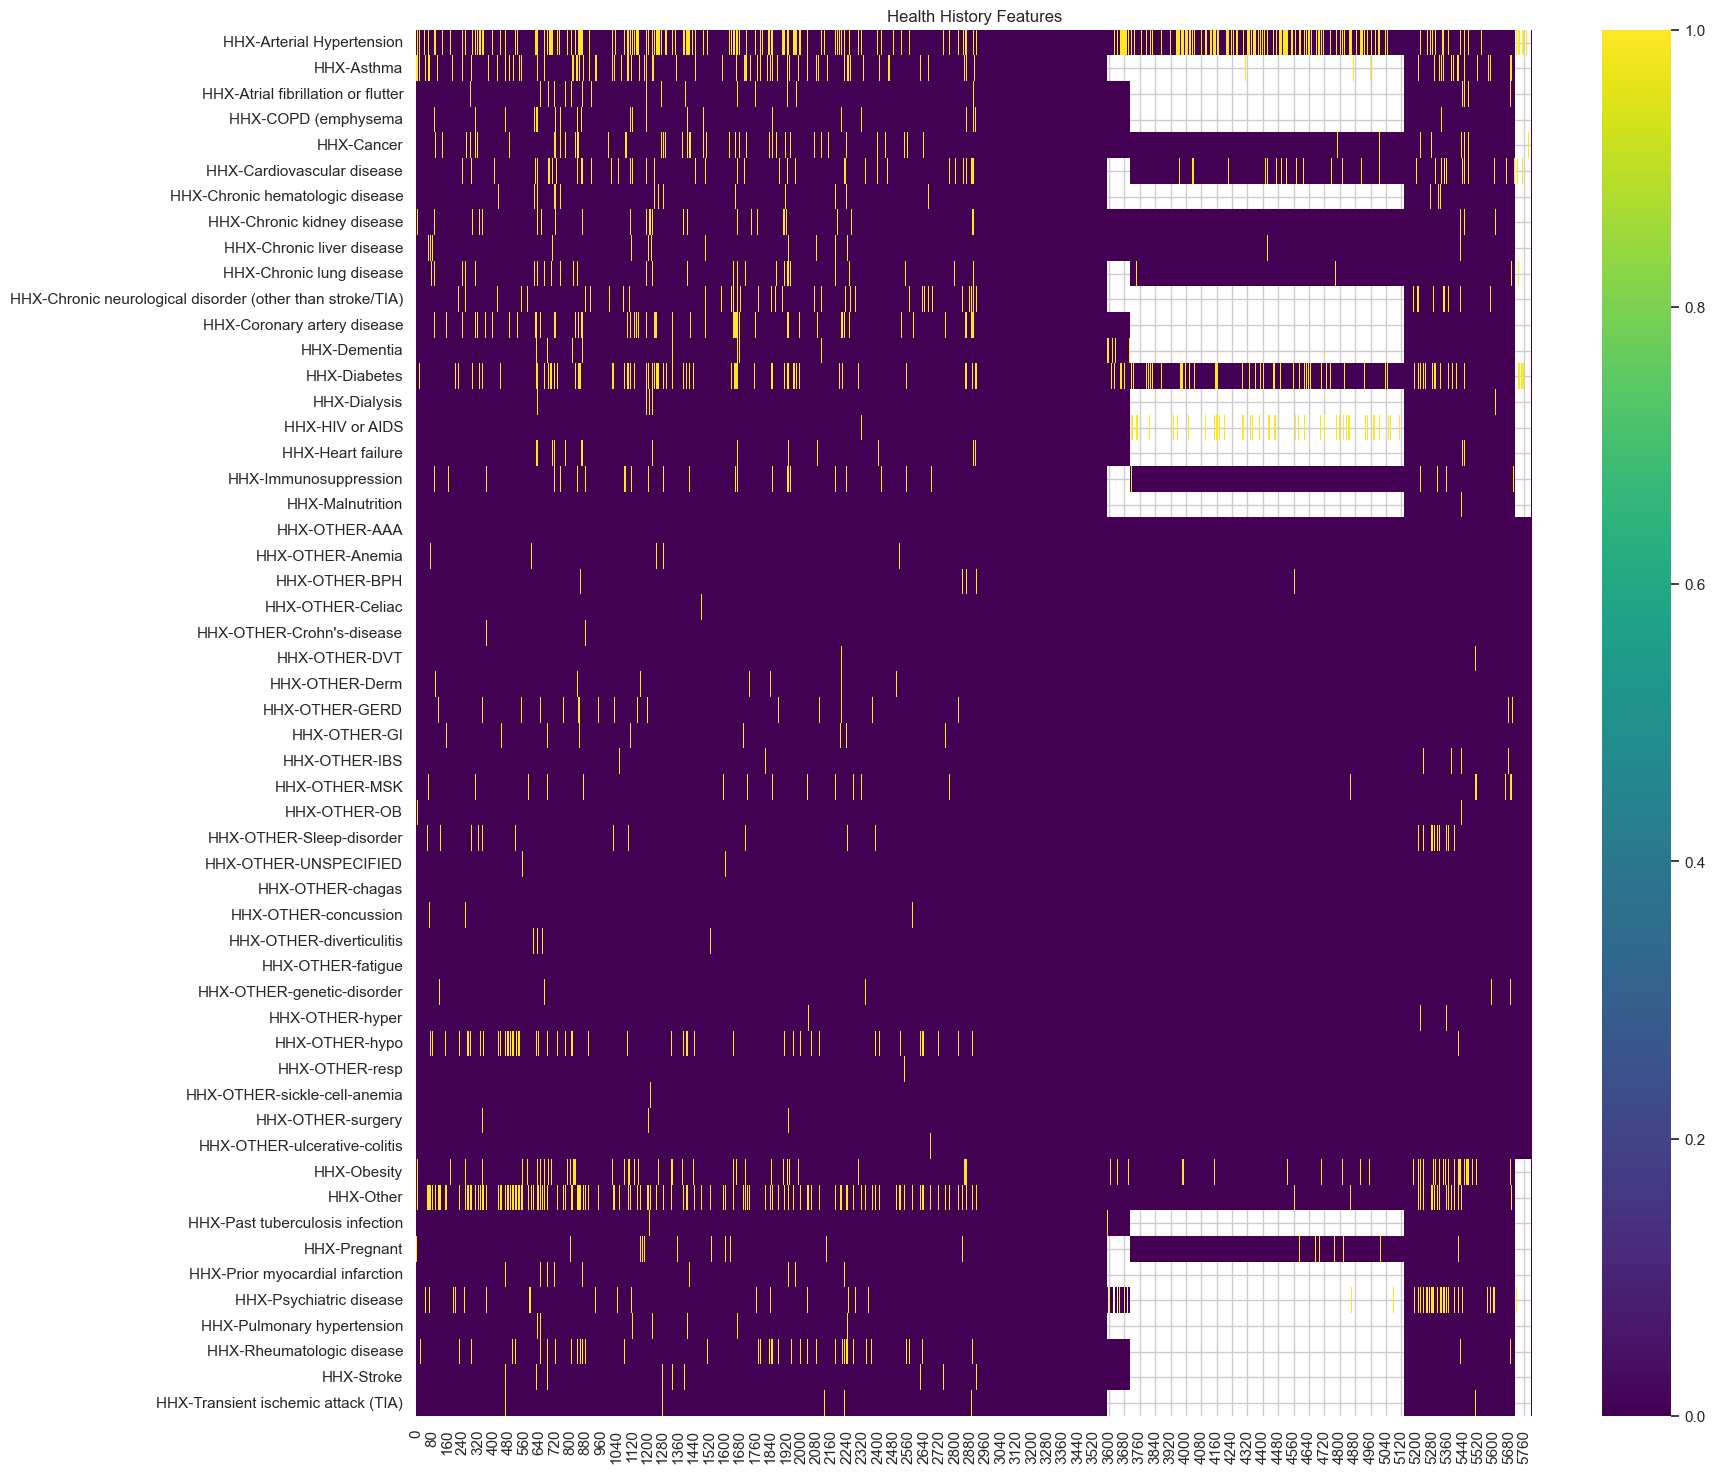

In [160]:
fig, ax = plt.subplots(figsize=(18,18))
sns.heatmap(hx_features_all.T, cbar=True, ax = ax, cmap = 'viridis')
plt.title("Health History Features")

## SURVEYS

In [161]:
# add up the health history information

# surveys
GAD    = [col for col in df_columns if "_gad" in col if "complete" not in col]
PROMIS = [col for col in df_columns if "promis29" in col]
PHQ    = [col for col in df_columns if "phq" in col]

# remove gad_complete from GAD
# it's scooped up in the above line
# GAD = [gad for gad in GAD if "complete" not in gad]

# completeness
# these columns were intermedaries and are not useful in the analysis, so we don't need these
# PHX_COMPLETE    = ["phx_complete"]
# PROMIS_COMPLETE = [col for col in df_columns if "promis_29_profile" in col]
# PHQ_COMPLETE    = [col for col in df_columns if "patient_health_questionaire" in col]

# the set of survey columns
SURVEYS = GAD + PROMIS + PHQ

In [162]:
survey_features = df[SURVEYS]
survey_features.shape

(5802, 47)

<Axes: >

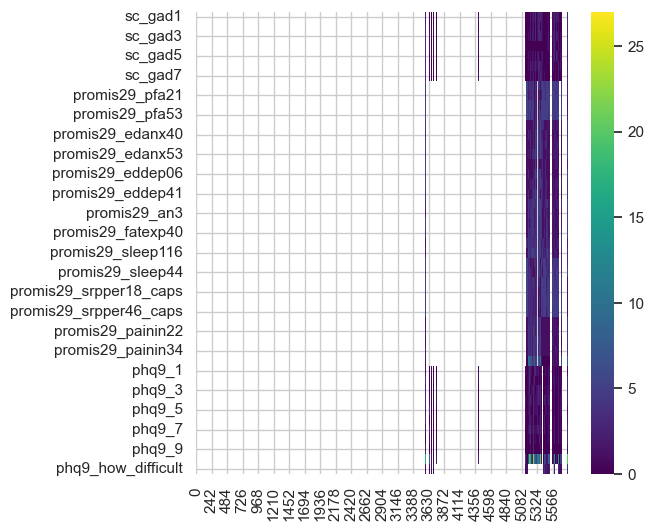

In [163]:
# plot it as a heatmap
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(survey_features.T, cbar=True, ax = ax, cmap = 'viridis')

### CONCLUSION:
- survey featureas are mostly missing, so we will not use them in the larger dataset


## SYMPTOMS

In [164]:
# read the list of symtpoms from the json file
import json
with open("./OUTPUT/list-symptoms.json", "r") as f:
    symptoms_list = json.load(f)

# get all columns that start with the symptoms list
SYMP = [col for col in df.columns if  col.startswith(tuple(symptoms_list))]

# feature set for symptoms
symptom_features = df[SYMP]



# given that the patients were asked to mark yes/no, we assume that no response is equivalent to a "no"
# QUESTION: is this reasonable?
# symptom_features = symptom_features.fillna(0)

# there are symptom features with a value of 2 - replace with 1
symptom_features = symptom_features.replace(2, 1)

# rename by prefixing sith SYMP
symptom_features.columns = [f"SYMPT-{col}" for col in symptom_features.columns]

# sort alphabetically
symptom_features = symptom_features.reindex(sorted(symptom_features.columns), axis=1)

symptom_features.shape

(5802, 56)

In [165]:
# how many nulls per site?
print("Missing SYMPTOM values by site:")
# df.groupby('dag')[SYMP].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing SYMPTOM values by site:


<Axes: >

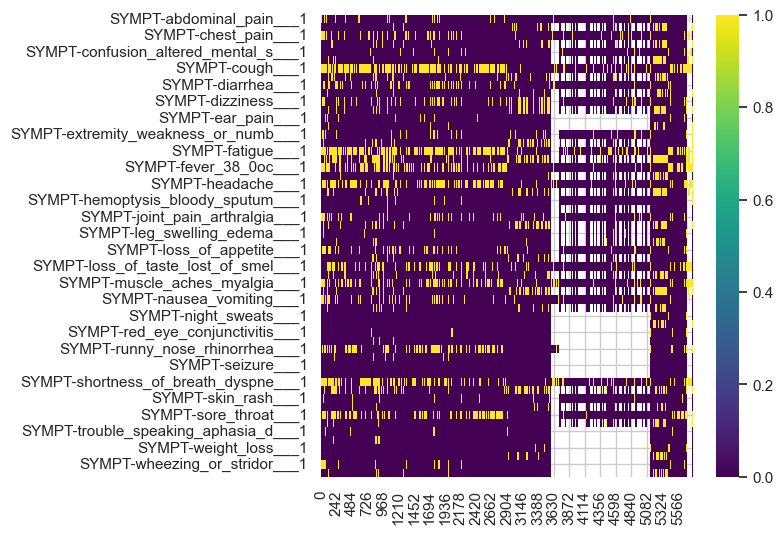

In [166]:
fig, ax = plt.subplots(figsize=(6,6))
# norm = mc.LogNorm(vmin=1, vmax=10)
sns.heatmap(symptom_features.T, cbar=True, ax = ax, norm = None,cmap = 'viridis')

## CLINICAL TESTS (AKA LABS)


- all zero: lung_function, metacholine, spirometry
- consider dropping: ct*, cx*, echo*, ekg* - similarly, mostly empty
- consider dropping features with < 200 items

In [167]:

s = "igg	wbc	neutrophil	neutrophil_count	lymphocyte	lymphocyte_count	monocyte	monocyte_count	eosinophil	eosinophil_count	basophil	basophil_count	platelets	haemoglobin	urea	creatinine	ntprobnp	bnp	sodium	potassium	crp	ldh	cpk	albumin		ast	alt	pct	troponinthigh	troponinihigh	troponint	troponini	aptt	inr	triglycerides	bilirubin	bilirubin_direct	glucose	fibrinogen	ferritin	il6	cd4	cd8	angiography	pocus	echocardiogram	echoresult	ekg	ekgresult	ekgcode	stented	cxr	cxrresult	cxrcode	cta	ctaresult	ctt	cttresult	cth	cthresult	imaging_results	imaging	spirometry	spirometryresult	metacholine	lung_function	lung_functionresult"
words = s.split()
words.sort()
CLINICAL_TESTS = words

# remove imaging_results from the list
CLINICAL_TESTS.remove("imaging_results")

In [168]:
# remove columns that have less than 200 non-null points
# CLINICAL_TESTS = [col for col in CLINICAL_TESTS if df[col].count() > 200]

### Investigate some of the features

In [169]:

# drop features starting with ctt and cx
# CLINICAL_TESTS = [col for col in CLINICAL_TESTS if not col.startswith(("ctt", "cth", "cta", "cx", "echo", "ekg"))]


In [170]:
# count items that start with ct
df.filter(regex='^ct', axis = 1).count()

cta           33
ctaresult     28
ctt          254
cttresult    248
cth           34
cthresult      6
dtype: int64

In [171]:
df["ctaresult"].value_counts(), df["cttresult"].value_counts(), df["cthresult"].value_counts()

(ctaresult
 2.0    23
 0.0     3
 1.0     2
 Name: count, dtype: int64,
 cttresult
 2.0    229
 1.0     15
 0.0      4
 Name: count, dtype: int64,
 cthresult
 0.0    4
 1.0    2
 Name: count, dtype: int64)

In [172]:
# CTA, CTT, CTH
# most of the results are 2 - no report

# CONCLUSION: recommend dropping these - there are very few discriminant results


In [173]:
# count items that start with ct
df.filter(regex='^cx', axis = 1).count()

cxr          295
cxrresult    252
cxrcode       40
dtype: int64

In [174]:
# count cxr code values
df["cxrresult"].value_counts()

# most are no-result. Of the 39 that are a positive finding, what are the results?

cxrresult
2.0    150
0.0     63
1.0     39
Name: count, dtype: int64

In [175]:
df["cxrcode"].value_counts()

# 33 fluid, etc
# 3 fibrosis
# 2 nodules, cysts
# 2 congestive heart disease etc

cxrcode
2.0    33
4.0     3
3.0     2
8.0     2
Name: count, dtype: int64

In [176]:
# CONCLUSION: recommend dropping these too - very small numbers

In [177]:
# now echo
# count items that start with ct
df.filter(regex='^echo', axis = 1).count()

echocardiogram    200
echoresult        194
dtype: int64

In [178]:
df["echoresult"].value_counts()
# mostly no reports, 7 positive findings

echoresult
2.0    168
0.0     19
1.0      7
Name: count, dtype: int64

In [179]:
# finally, ekg
print(df.filter(regex='^ekg', axis = 1).count())

print(df["ekgresult"].value_counts())

print(df["ekgcode"].value_counts())

# ekgcode results indicate 
# 10 sinus bradycardia
# 2 atrioventricular block
# 1 each of supraventricular, sinus tachy, infarction

# CONCLUSION: still recommend dropping all of the ct*, cx*, echo*, ekg* 
# numbers are very very small

ekg          219
ekgresult     46
ekgcode       15
dtype: int64
ekgresult
0.0    27
1.0    15
2.0     4
Name: count, dtype: int64
ekgcode
2.0     10
6.0      2
4.0      1
12.0     1
3.0      1
Name: count, dtype: int64


In [180]:
# OTHER FEATURES:
# - angiography is 7 zeroes and the rest blank
# - imaging = 12 records, imaging_results all blank
# - spirometry = 2053 records
# - spriometry_result = 27 records, of which 7 neg, 12 no report, 8 positive
# - lung_function_result = 31 records, 17 neg, 6 no report, 8 positive

In [181]:
# count all values in features
df[CLINICAL_TESTS].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5802 entries, 0 to 5801
Data columns (total 65 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   albumin              1354 non-null   float64
 1   alt                  1718 non-null   float64
 2   angiography          7 non-null      float64
 3   aptt                 580 non-null    float64
 4   ast                  1055 non-null   float64
 5   basophil             568 non-null    float64
 6   basophil_count       842 non-null    float64
 7   bilirubin            1433 non-null   float64
 8   bilirubin_direct     703 non-null    float64
 9   bnp                  18 non-null     float64
 10  cd4                  2 non-null      float64
 11  cd8                  2 non-null      float64
 12  cpk                  151 non-null    float64
 13  creatinine           1471 non-null   float64
 14  crp                  1658 non-null   float64
 15  cta                  33 non-null     f

In [182]:
# CONCLUSION SUMMARY
# drop cx*, ct*, echo*, ekg*, angiography, imaging, spiromoetry, lung_function, cd4, cd8, stented, tropinin, igg, 

In [183]:
# drop the columns
CLINICAL_TESTS = [col for col in CLINICAL_TESTS if not col.startswith(("ctt", "cth", "cta", "cx", "echo", "ekg", "angiography", "imaging", "spirometry", "lung_function", "cd4", "cd8", "stented", "troponin", "pocus", "igg", "ntprobnp", "bnp"))]

df[CLINICAL_TESTS].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5802 entries, 0 to 5801
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   albumin           1354 non-null   float64
 1   alt               1718 non-null   float64
 2   aptt              580 non-null    float64
 3   ast               1055 non-null   float64
 4   basophil          568 non-null    float64
 5   basophil_count    842 non-null    float64
 6   bilirubin         1433 non-null   float64
 7   bilirubin_direct  703 non-null    float64
 8   cpk               151 non-null    float64
 9   creatinine        1471 non-null   float64
 10  crp               1658 non-null   float64
 11  eosinophil        522 non-null    float64
 12  eosinophil_count  843 non-null    float64
 13  ferritin          905 non-null    float64
 14  fibrinogen        765 non-null    float64
 15  glucose           1043 non-null   float64
 16  haemoglobin       1976 non-null   float64


Text(0.5, 1.0, 'Clinical Tests')

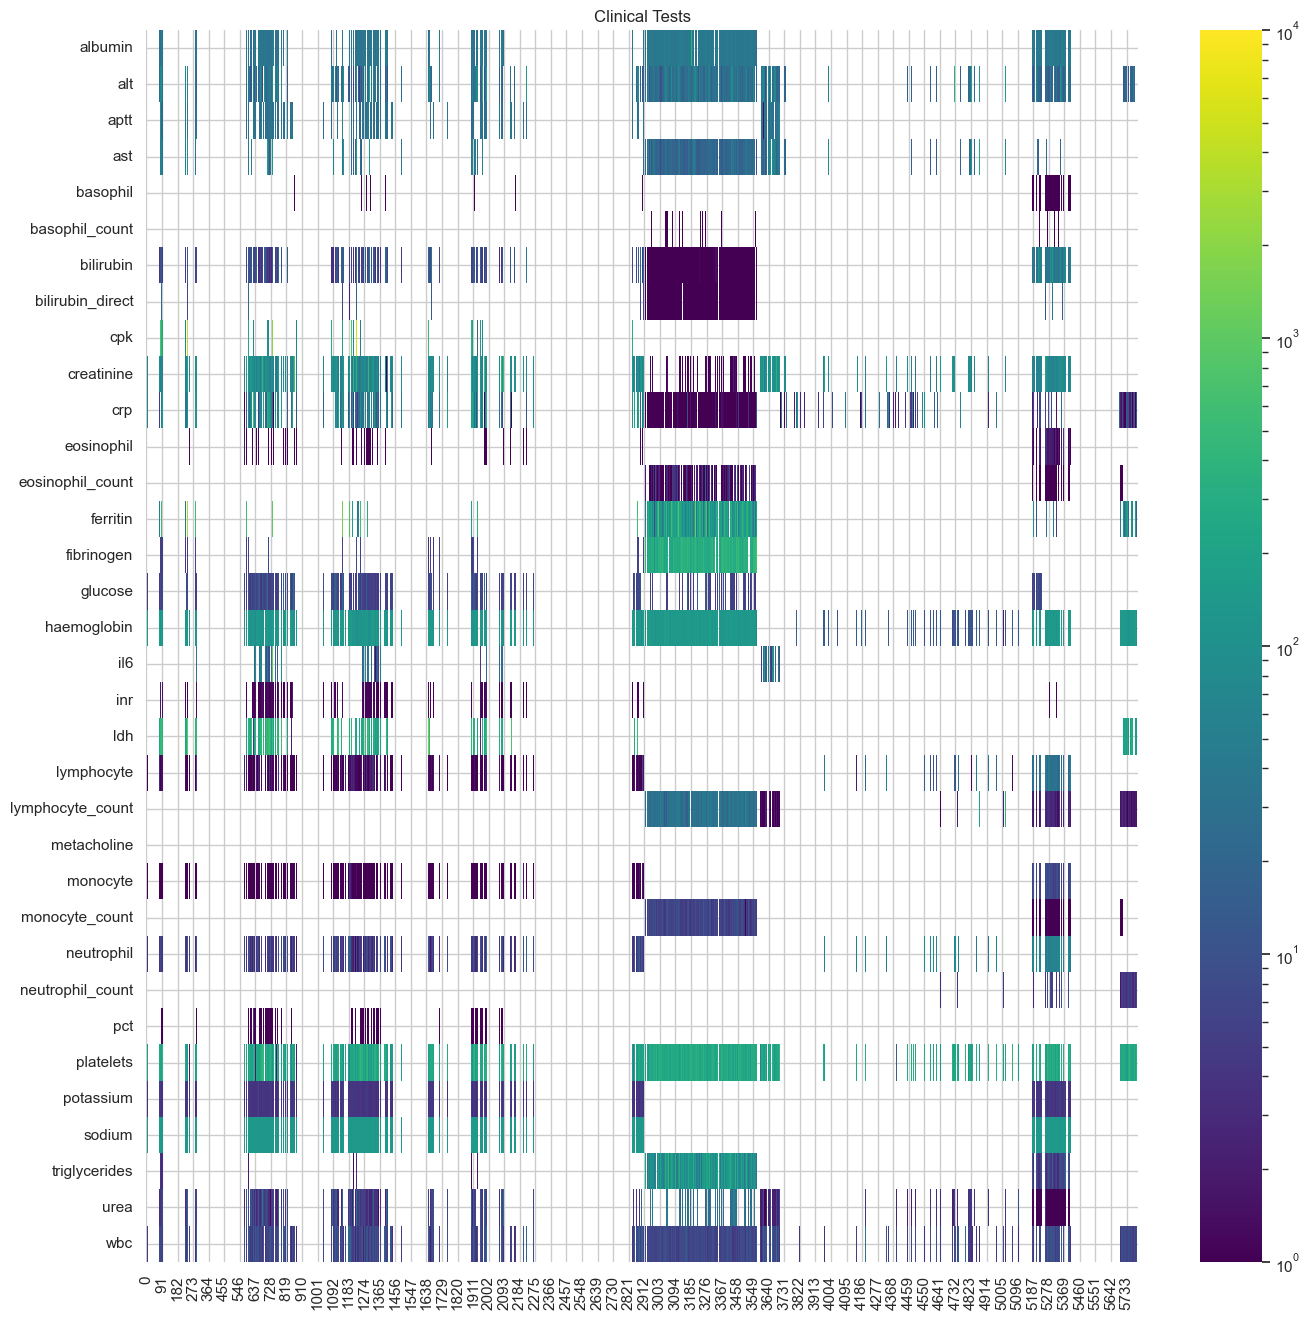

In [184]:
fig, ax = plt.subplots(figsize=(16,16))
norm = mc.LogNorm(vmin=1, vmax=10_000)
sns.heatmap(df[CLINICAL_TESTS].T, cbar=True, ax = ax, norm = norm, cmap = 'viridis')
plt.title("Clinical Tests")

In [185]:
# how many nulls per site?
print("Missing CLINICAL values by site:")
df.groupby('dag')[CLINICAL_TESTS].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T.map(lambda x: f"{x:,}") # type: ignore


Missing CLINICAL values by site:


dag,LDN,MTL,SAN,RIO,LUS
albumin,315,"2,395",105,160,"1,473"
alt,246,"2,303",107,49,"1,379"
aptt,318,"2,436",301,694,"1,473"
ast,319,"2,728",268,49,"1,383"
basophil,319,"2,523",123,796,"1,473"
basophil_count,300,"2,913",123,151,"1,473"
bilirubin,313,"2,323",104,156,"1,473"
bilirubin_direct,319,"2,867",285,155,"1,473"
cpk,313,"2,768",301,796,"1,473"
creatinine,308,"2,100",103,479,"1,341"


In [186]:
# how many nulls by LC_STATUS?
print("Missing CLINICAL values by LC_STATUS:")
df.groupby('LC_STATUS')[CLINICAL_TESTS].apply(lambda x: x.isnull().sum()).T.map(lambda x: f"{x:,}") # type: ignore

Missing CLINICAL values by LC_STATUS:


LC_STATUS,HC,LC_NEG,LC_POS
albumin,81,"2,977","1,390"
alt,81,"2,765","1,238"
aptt,81,"2,904","2,237"
ast,81,"2,983","1,683"
basophil,81,"3,059","2,094"
basophil_count,81,"3,258","1,621"
bilirubin,81,"2,949","1,339"
bilirubin_direct,81,"3,227","1,791"
cpk,81,"3,176","2,394"
creatinine,81,"2,642","1,608"


In [187]:
# treat outliers before imputing data
# if we even impute the data

from project_modules.data_prep import treat_outliers
labs_without_outliers = treat_outliers(df[CLINICAL_TESTS], z_threshold = 4, method = "median")

>>> Using z-threshold = 4.00 to identify outliers.
>>> There are 193 outliers in the data for abs(z) ≥ 4.00.
>>> Outliers are 3.33% of the total data.
>>> Replacing outliers with median.


/Users/david/mambaforge/envs/lm2/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [188]:
labs_without_outliers.describe()

,albumin,alt,aptt,ast,basophil,basophil_count,bilirubin,bilirubin_direct,cpk,creatinine,...,monocyte_count,neutrophil,neutrophil_count,pct,platelets,potassium,sodium,triglycerides,urea,wbc
count,1354.000000,1718.000000,580.000000,1055.000000,568.000000,842.000000,1433.000000,703.000000,151.000000,1471.000000,...,843.000000,1014.000000,156.000000,363.000000,2037.000000,1019.000000,1020.000000,840.000000,1254.000000,2049.000000
mean,39.663516,37.982974,32.917483,32.831403,0.134331,0.102969,11.994487,1.507255,387.033113,82.975471,...,6.042942,18.182546,4.891282,0.395234,252.652626,4.092836,137.535294,113.893690,10.364152,7.559058
std,14.773856,40.908440,13.793910,35.401060,0.209225,0.303257,26.885779,5.662524,1024.353601,104.072817,...,17.245296,23.001281,6.706585,1.134721,97.245811,0.641200,4.265217,121.384291,13.899937,3.991817
min,17.000000,5.000000,1.400000,1.600000,0.000000,0.000000,0.000000,0.000000,12.000000,0.600000,...,0.000000,0.600000,1.400000,0.020000,1.000000,2.200000,115.000000,0.700000,0.300000,1.000000
25%,36.250000,19.000000,27.275000,17.050000,0.000000,0.000000,0.500000,0.100000,52.500000,55.000000,...,3.000000,4.000000,3.197500,0.080000,189.000000,3.700000,135.000000,18.725000,2.500000,5.400000
50%,40.000000,28.000000,31.550000,23.000000,0.000000,0.000000,4.000000,0.100000,107.000000,71.000000,...,6.000000,6.400000,4.300000,0.130000,243.000000,4.000000,138.000000,95.000000,4.800000,6.900000
75%,42.000000,42.000000,35.425000,34.500000,0.200000,0.000000,11.000000,0.100000,275.500000,91.936000,...,8.000000,16.000000,5.150000,0.250000,304.000000,4.400000,140.000000,154.250000,10.600000,8.800000
max,404.000000,921.000000,240.000000,478.600000,1.400000,2.000000,680.700000,53.000000,9650.000000,1762.000000,...,496.800000,86.900000,85.600000,11.750000,1480.000000,13.300000,160.000000,1589.000000,162.000000,81.700000


In [189]:
# # sklearn median imputer

# from sklearn.impute import SimpleImputer
# imp = SimpleImputer(strategy='median')

# clinical_test_features = b.copy()

# ctf_imputed = pd.DataFrame(imp.fit_transform(clinical_test_features), columns = clinical_test_features.columns)

# print(ctf_imputed.shape)


# clin_test_features = ctf_imputed
# # rename the columns with CLIN- prefix
# clin_test_features.columns = [f"CLIN-{col}" for col in clin_test_features.columns]


# # plot the heatmap
# fig, ax = plt.subplots(figsize=(16, 16))
# norm = mc.LogNorm(vmin=1, vmax=10_000)
# sns.heatmap(clin_test_features.T, cbar=True, ax = ax, norm = norm)
# # set text size smaller
# plt.xticks(fontsize=8); plt.yticks(fontsize=8);
# plt.title("Clinical Tests - Imputed with Median")


# # find columns that are all zero
# all_zero = clin_test_features.columns[(clin_test_features == 0).all()]

# print(all_zero)

# # drop the all zero columns
# clin_test_features = clin_test_features.drop(columns = all_zero)

In [190]:
# WIP: DO NOT IMPUTE
# lab_features = df[CLINICAL_TESTS]

lab_features = labs_without_outliers

# rename the colummns by prefixing with LABS
lab_features.columns = [f"LABS-{col}" for col in lab_features.columns]

lab_features.shape

(5802, 34)

In [191]:
lab_features.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5802 entries, 0 to 5801
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   LABS-albumin           1354 non-null   float64
 1   LABS-alt               1718 non-null   float64
 2   LABS-aptt              580 non-null    float64
 3   LABS-ast               1055 non-null   float64
 4   LABS-basophil          568 non-null    float64
 5   LABS-basophil_count    842 non-null    float64
 6   LABS-bilirubin         1433 non-null   float64
 7   LABS-bilirubin_direct  703 non-null    float64
 8   LABS-cpk               151 non-null    float64
 9   LABS-creatinine        1471 non-null   float64
 10  LABS-crp               1658 non-null   float64
 11  LABS-eosinophil        522 non-null    float64
 12  LABS-eosinophil_count  843 non-null    float64
 13  LABS-ferritin          905 non-null    float64
 14  LABS-fibrinogen        765 non-null    float64
 15  LABS

## CLINICAL DETAILS

In [192]:
# read the list of symtpoms from the json file
import json
with open("./OUTPUT/list-clin-details.json", "r") as f:
    cd_list = json.load(f)

# get all columns that start with the symptoms list
CD = [col for col in df.columns if  col.startswith(tuple(cd_list))]

# delete items that sstart with phx and phq
# the are scooped up by accident because cd_list contains "ph"
CD = [col for col in CD if not col.startswith(("phx", "phq"))]

# feature set for symptoms
cd_features = df[CD]

# preprend CLIN- to the column names
cd_features.columns = [f"CD-{col}" for col in cd_features.columns]

# find spaces in the data and replace with zero
cd_features = cd_features.replace(" ", 0)

In [193]:
cd_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5802 entries, 0 to 5801
Columns: 320 entries, CD-pregnant to CD-o2_saturation
dtypes: datetime64[ns](6), float64(310), object(4)
memory usage: 14.2+ MB


In [194]:
# drop columns with dtype datetime64
cd_features = cd_features.select_dtypes(exclude = ['datetime64'])
cd_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5802 entries, 0 to 5801
Columns: 314 entries, CD-pregnant to CD-o2_saturation
dtypes: float64(310), object(4)
memory usage: 13.9+ MB


In [195]:
# which cols are of type object?
cd_features.select_dtypes(include = ['object']).columns

Index(['CD-covid_test_date_1', 'CD-covid_test_date_2',
       'CD-date_of_hospitalization', 'CD-specify_other_med'],
      dtype='object')

In [196]:
# drop the object columns as they are either dates or mostly spaces
cd_features = cd_features.select_dtypes(exclude = ['object'])
cd_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5802 entries, 0 to 5801
Columns: 310 entries, CD-pregnant to CD-o2_saturation
dtypes: float64(310)
memory usage: 13.7 MB


Text(0.5, 1.0, 'CLINICAL DETAIL Status- missing values are light coloured')

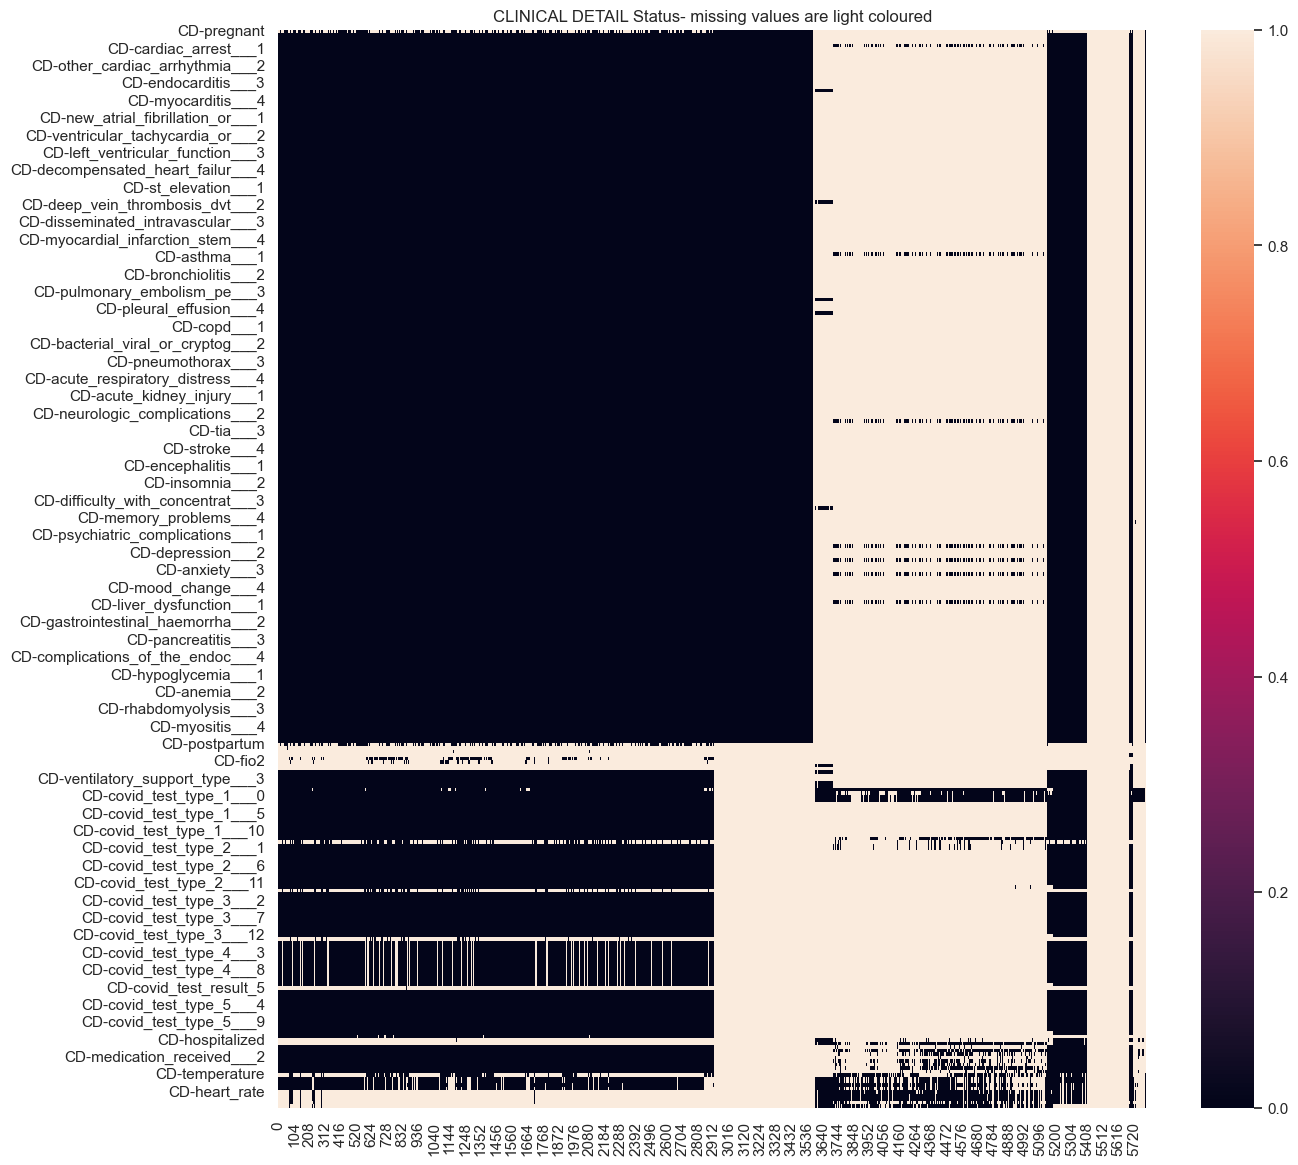

In [197]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(14, 14))

sns.heatmap(cd_features.isnull().T, cbar=True, ax = ax, )
plt.title("CLINICAL DETAIL Status- missing values are light coloured")

In [198]:
# these features are not very informative - consider dropping them
cd_features = cd_features.drop(columns = cd_features.filter(like = "test_type").columns)

# height in metres and centimetres is redundant
# drop the height in cm
cd_features = cd_features.drop(columns = "CD-height_cm")

cd_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5802 entries, 0 to 5801
Columns: 244 entries, CD-pregnant to CD-o2_saturation
dtypes: float64(244)
memory usage: 10.8 MB


In [199]:
# sort alphabetically
cd_features = cd_features.reindex(sorted(cd_features.columns), axis=1)

Text(0.5, 1.0, 'CLINICAL DETAIL Status - missing values are light coloured')

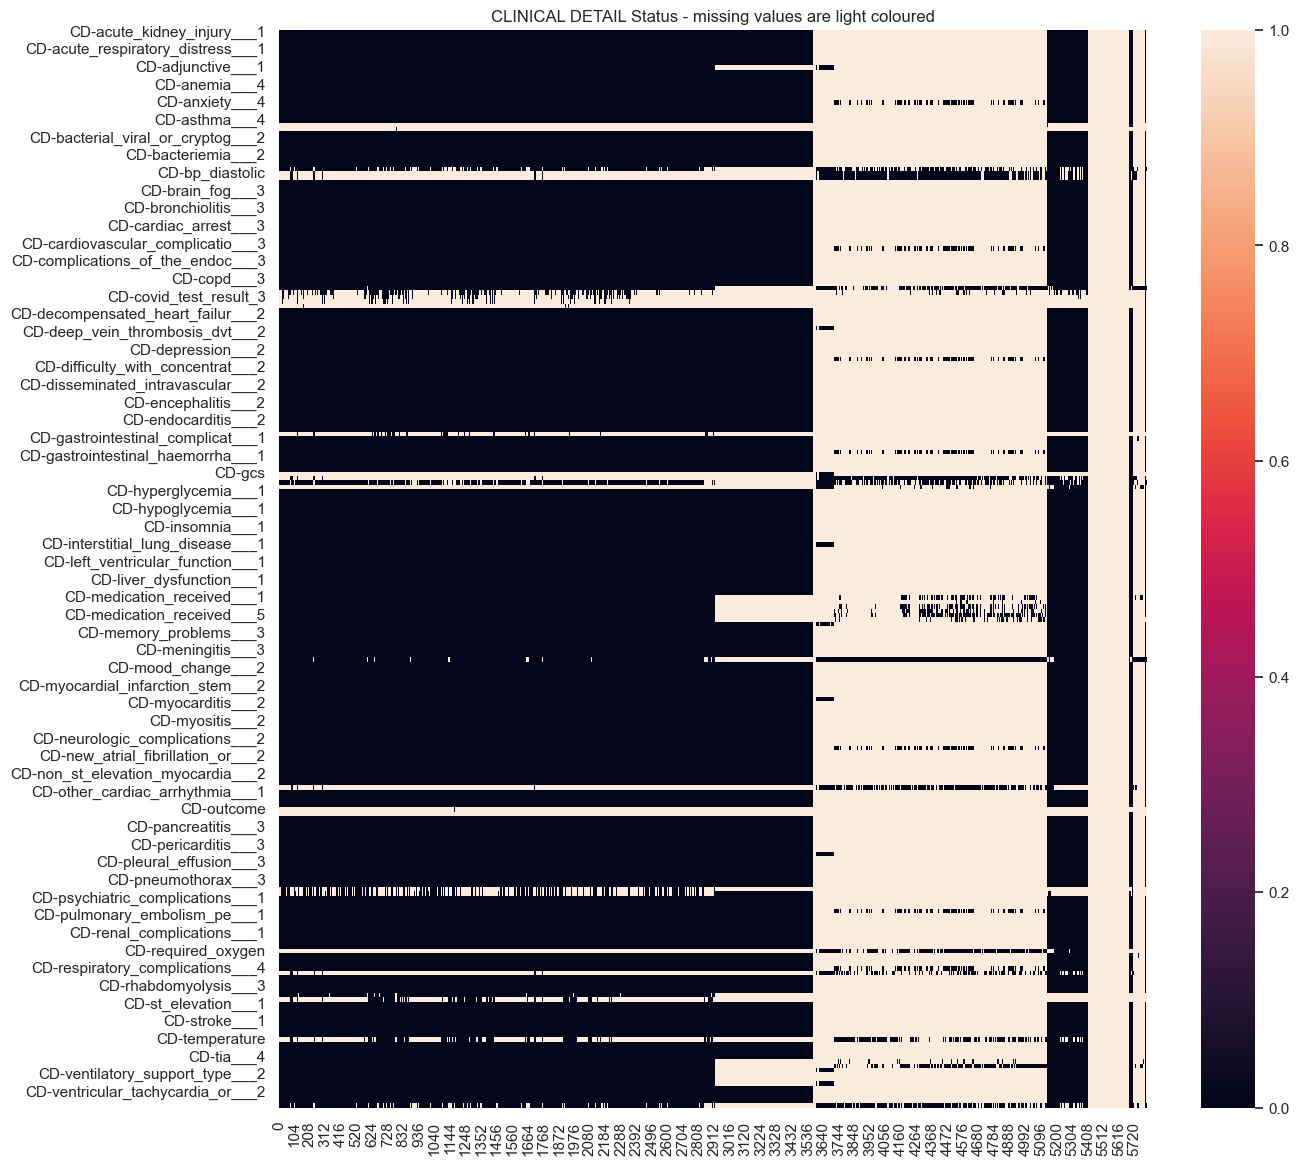

In [200]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(14, 14))

sns.heatmap(cd_features.isnull().T, cbar=True, ax = ax, )
plt.title("CLINICAL DETAIL Status - missing values are light coloured")

In [201]:
# missing values by site
print("Missing CLINICAL DETAILS values by site:")

cd_features.groupby(df['dag']).apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing CLINICAL DETAILS values by site:


dag,LDN,MTL,SAN,RIO,LUS
CD-acute_kidney_injury___1,288,0,74,137,1427
CD-acute_kidney_injury___2,288,0,74,137,1427
CD-acute_kidney_injury___3,288,0,74,137,1427
CD-acute_kidney_injury___4,288,0,74,137,1427
CD-acute_respiratory_distress___1,288,0,74,137,1427
...,...,...,...,...,...
CD-ventricular_tachycardia_or___1,288,0,74,137,1427
CD-ventricular_tachycardia_or___2,288,0,74,137,1427
CD-ventricular_tachycardia_or___3,288,0,74,137,1427
CD-ventricular_tachycardia_or___4,288,0,74,137,1427


## VACCINES

In [202]:
# patient vaccination status
VAX_STATUS = ["vaccinated"]

# given a list of substrings, find aall columns that contain the substrings
def find_columns(df_columns, substrings):
    return [col for col in df_columns if any(substring in col for substring in substrings)]

VAX = find_columns(df_columns, ["astra_zeneca", "pfizer", "moderna", "j_j", "sinoppharm", "sinovac", "sputnik", "other___"])

# unstructured text - save for later analysis
VAX_SIDE_EFFECTS = find_columns(df_columns, ["vac_sideeffect"])

# QUESTION: is the assumption to fill blank values with 0 correct?
# df[VAX] = df[VAX].fillna(0)

# use all features
# vax_features = df[VAX_STATUS + VAX]

# for now, select only vaccine status
vax_features = df[VAX_STATUS]

print(vax_features.shape)

# prefix VAX- to the column names
vax_features.columns = [f"VAX-{col}" for col in vax_features.columns]


(5802, 1)


Text(0.5, 1.0, 'Vaccination Status - missing values are light coloured')

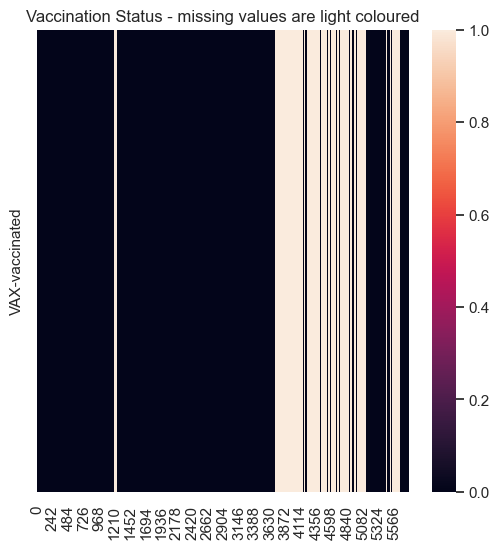

In [203]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(6,6))

sns.heatmap(vax_features.isnull().T, cbar=True, ax = ax, )
plt.title("Vaccination Status - missing values are light coloured")

In [204]:
# # how many nulls per site?
# print("Missing VACCINE values by site:")
# df.groupby('dag')[VAX + VAX_STATUS].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T


### CONCLUSION:
- use only the vaccine status (binary)

# SAVE FEATURES TO FILE

- fill  na with 0 in vax, symptoms
- 

In [205]:
# demographic_features
# medication_features
# hx_features_all
# survey_features
# symptom_features
# clinical_features
# vax_features

# concatenate all of the features
features = pd.concat([
                        demographic_features, 
                        medication_features, 
                        symptom_features, 
                        vax_features,
                        hx_features_all, 
                        lab_features, 
                        cd_features,
                        # WIP: 
                        # none
                        # NOT SELECTED:
                        # survey_features,    # not selected
                        # substance_features, # not selected
                      ], axis = 1)

features["LC_STATUS"] = df["LC_STATUS"]

In [206]:
features.shape

(5802, 420)

In [207]:
# count the nulls per site
print("Missing values by site:")

features.groupby('dag').apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T.sum()

Missing values by site:


dag
LDN     86669
MTL    138722
SAN     28255
RIO     78838
LUS    444826
dtype: int64

Text(0.5, 1.0, 'Missing values - light coloured cells are missing')

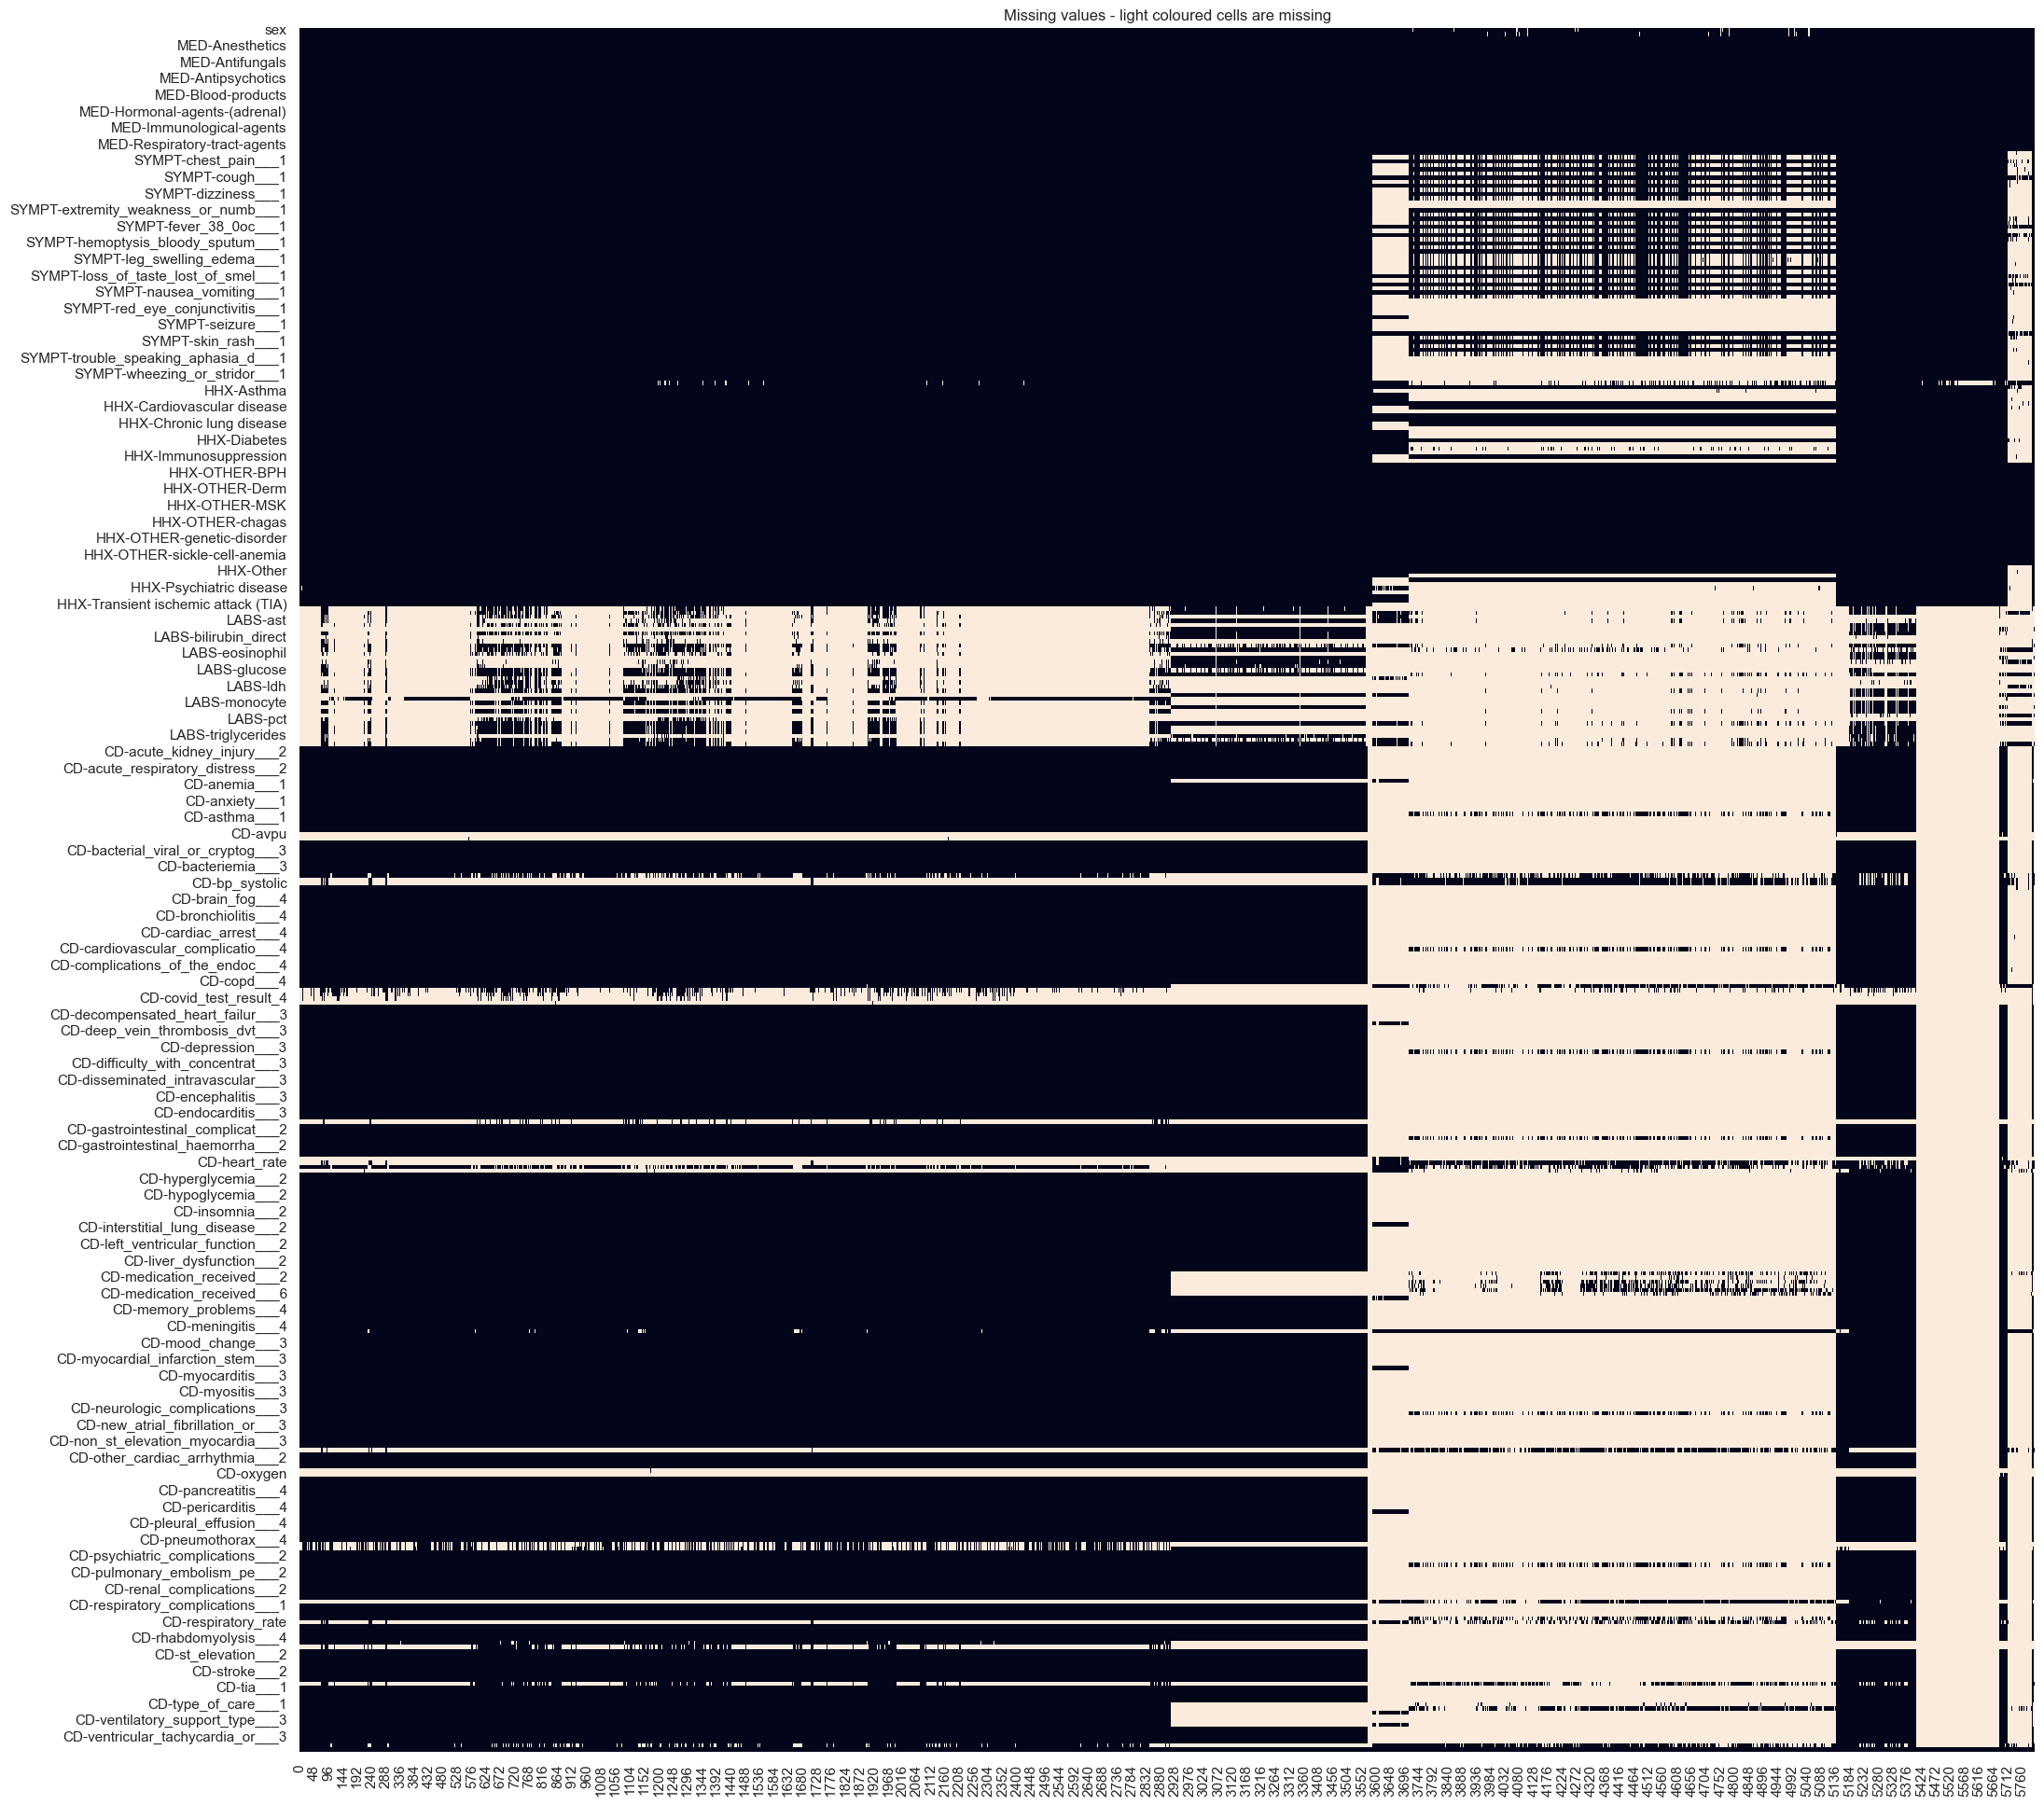

In [208]:
fig, ax = plt.subplots(figsize=(24, 24))

sns.heatmap(features.isnull().T, cbar=False, ax = ax)

plt.title("Missing values - light coloured cells are missing")

In [209]:
# preserve the features dataframe
# features.to_pickle("../lc-project-data/features.pkl")

# save the features dataframe to an excel file
# features.to_excel("../lc-project-data/features.xlsx", index = False)

# save the features dataframe to a csv file
# features.to_csv("../lc-project-data/features.csv")



In [210]:

# using the arrow dataset format is way faster than excel
# ~0.0s vs > 15s for the excel file

import datasets

# make a dataset
ds = datasets.arrow_dataset.Dataset.from_pandas(features)
ds.save_to_disk("../lc-project-data/features.arrow")

/Users/david/mambaforge/envs/lm2/lib/python3.11/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


# QUICK TEST

In [211]:
# train a RFC to predic LC_STATUS
from sklearn.ensemble import RandomForestClassifier

# get an xxgb classifier
from xgboost import XGBClassifier



# select only rows that have LC_STATUS != HC
features = features.query('LC_STATUS != "HC"')


# drop the LC_STATUS column
try:
    X = features.drop(columns = ["LC_STATUS", "record_id","dag","age"])
except KeyError:
    X = features.drop(columns = ["LC_STATUS", "dag", "age"])

# quick and dirty
X.fillna(0, inplace = True)



# target variable
# y = features["dag"]
# y = y.map({1:0, 2:1, 3:2, 4:3, 5:4})

# map y to integers
y = features["LC_STATUS"].map({"LC_POS": 1, "LC_NEG": 0})


# create a random forest classifier

# clf = RandomForestClassifier(n_estimators = 1_000, 
#                              max_depth = 3,
#                              random_state = 42)

clf = XGBClassifier(n_estimators = 1_000, 
                    max_depth = 3,
                    random_state = 42)


# fit the model
clf.fit(X, y)

# get the feature importances

feature_importances = clf.feature_importances_

In [212]:
feature_importances = pd.Series(feature_importances, index = X.columns).sort_values(ascending = False)

In [213]:
feature_importances[:10]

LABS-monocyte_count                     0.617215
LABS-lymphocyte_count                   0.046768
LABS-triglycerides                      0.020117
SYMPT-fatigue___2                       0.012850
CD-adjunctive___1                       0.012607
SYMPT-loss_of_taste_lost_of_smel___2    0.010662
SYMPT-shortness_of_breath_dyspne___2    0.010333
CD-medication_received___4              0.009798
SYMPT-muscle_aches_myalgia___2          0.008262
SYMPT-dizziness___2                     0.005793
dtype: float32

In [214]:
# check rfc accuracy
from sklearn.model_selection import cross_val_score

cross_val_score(clf, X, y, cv = 10, scoring = "accuracy").mean()

0.7294218870135102

In [215]:
clf.predict(X)

array([1, 1, 1, ..., 1, 1, 1])

In [216]:
y.value_counts()

LC_STATUS
0    3260
1    2461
Name: count, dtype: int64

In [217]:
# confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y, clf.predict(X))


array([[3239,   21],
       [ 124, 2337]])